In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs, make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from tqdm import tqdm

from utils import visualize_decision_boundary, get_context_dist, evaluate
from src.model import MLP
from src.fseb import train_fseb
from src.utils import train_standard

dataset_type = 'moons'
sample_size = 250

In [2]:
# Generate Two Moons dataset
if dataset_type == 'moons':
    X, y = make_moons(n_samples=sample_size, noise=0.2, random_state=42)
elif dataset_type == 'circles':
    X, y = make_circles(n_samples=sample_size, noise=0.1, factor=0.5, random_state=42)
elif dataset_type == 'linear':
    X, y = make_classification(n_samples=sample_size, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
elif dataset_type == 'blobs':
    X, y = make_blobs(n_samples=sample_size, centers=2, n_features=2, random_state=42)
elif dataset_type == 'gaussian':
    X, y = make_gaussian_quantiles(n_samples=sample_size, n_features=2, n_classes=2, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

batch_size = 32
context_batch_size = 32

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

context_dist = get_context_dist(X_train, y_train, context_set_size=10000)
context_sampler = RandomSampler(context_dist, num_samples=context_batch_size, replacement=False)
context_subset_loader = DataLoader(context_dist, batch_size=context_batch_size, sampler=context_sampler)

Training Progress: 100%|██████████| 100/100 [00:37<00:00,  2.69epoch/s, Standard Acc=94.00%, FS-EB Acc=92.00%]


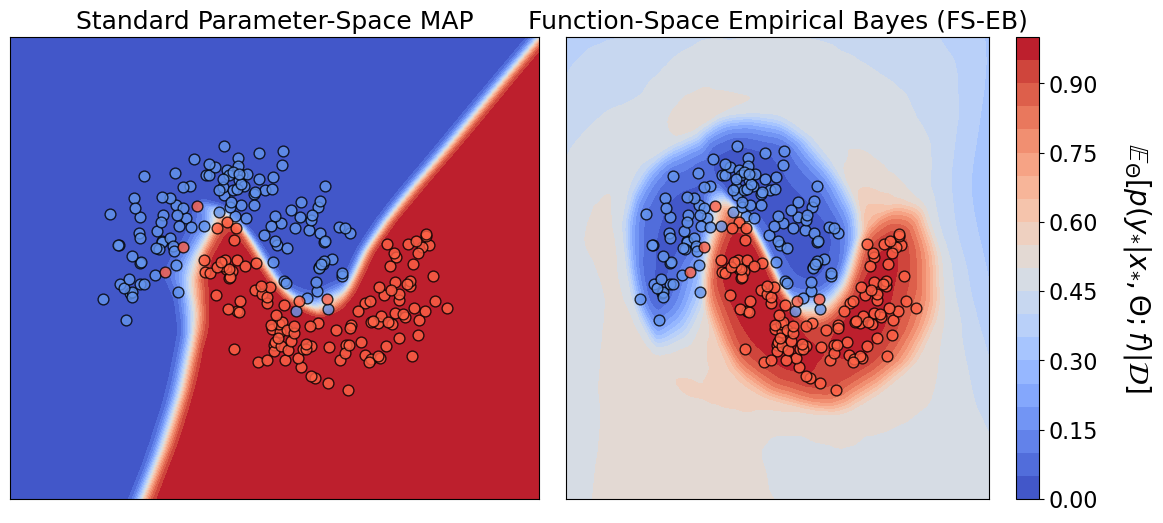

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
model_standard = MLP().to(device)
model_fseb = MLP().to(device)

# Initialize prior model (randomly initialized and frozen)
prior_model = MLP(prior=True).to(device)

# Define optimizers
optimizer_standard = optim.AdamW(model_standard.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer_fseb = optim.AdamW(model_fseb.parameters(), lr=1e-3, weight_decay=1e-4)

# Train models
num_epochs = 100
progress_bar = tqdm(range(num_epochs), desc="Training Progress", unit="epoch")

for epoch in progress_bar:
    # Train standard model
    model_standard = train_standard(model_standard, train_loader, optimizer_standard, device)
    
    # Train FS-EB model
    model_fseb = train_fseb(model_fseb, prior_model, train_loader, context_subset_loader, 
                            optimizer_fseb, device, tau_f=.1, tau_theta=1e-4, context_batch_size=context_batch_size)
    
    # Evaluate models every 10 epochs
    if (epoch + 1) % 10 == 0:
        standard_acc = evaluate(model_standard, test_loader, device)
        fseb_acc = evaluate(model_fseb, test_loader, device)
        
        # Update the tqdm progress bar with accuracy values
        progress_bar.set_postfix({
            "Standard Acc": f"{standard_acc:.2f}%",
            "FS-EB Acc": f"{fseb_acc:.2f}%"
        })

# Visualize decision boundaries
visualize_decision_boundary(
    [model_standard, model_fseb],
    ["Standard Parameter-Space MAP", "Function-Space Empirical Bayes (FS-EB)"],
    X, y, device, epoch=epoch, padding=1
)
